## Plots of seasonal variations in SST and surface flux, their correlation max time, and MLD

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33777/status,
Dashboard: /proxy/33777/status,Workers: 8
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45073,Workers: 8
Dashboard: /proxy/33777/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:43145,Total threads: 2
Dashboard: /proxy/33279/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:41455,


In [3]:
## load stuff for grid info

# files:
xch = 1440#*10#2*288
ych = 1080#*10#2*216

folder = '/g/data/e14/cy8964/Post_Process/temp/'
fgrd   = xr.open_dataset(folder + 'ocean_grid.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10,'xu_ocean':xch/10})
fwmass_m = xr.open_mfdataset(folder + 'output000fwmass_m_copy.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m,coords={"x":{"center":"grid_xt_ocean","right":"grid_xu_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
grid2 = Grid(fgrd,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m.neutral[1]-fwmass_m.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = grid2.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})
dx = grid2.diff(fgrd.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})
dyt = grid2.diff(fgrd.yu_ocean,'y',boundary='extend')
dxt = grid2.diff(fgrd.xu_ocean,'x',boundary='extend')

f_sc = xr.open_mfdataset(folder + 'seasonal_climatology_monthly_temp_SF_mld_compress.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
# this has monthly climatology SST, vertically integrated SF and MLD
fheat_mean = xr.open_mfdataset(folder + 'ocean_heat_mean.nc',combine='by_coords',chunks={'time': 1},decode_times = True)
fmonth_mean = xr.open_mfdataset(folder + 'ocean_month_mean.nc',combine='by_coords',chunks={'time': 1},decode_times = True)


# original: fheat_sc is monthly output climatologically avergaed.
# obj, obj2 = xr.broadcast(fheat_sc.sfc_hflux_pme,fheat_sc.temp_vdiffuse_sbc)
# sfc_hflux_pme_sc = obj.where(fheat_sc.st_ocean==fheat_sc.st_ocean[0],other=0.)
# fheat_sc["sfc_hflux_pme_sc"]=sfc_hflux_pme_sc
# fheat_sc["MX_cv"] = fheat_sc.temp_vdiffuse_diff_cbt + \
#                       fheat_sc.temp_nonlocal_KPP 
# fheat_sc["SF_cv"] = fheat_sc.temp_vdiffuse_sbc + \
#                       fheat_sc.sw_heat + \
#                       fheat_sc.frazil_3d + \
#                       sfc_hflux_pme_sc 
# stemp= fmonth_sc.temp.isel(st_ocean = 0)
# stemp.load()

# intheat = fheat_sc.SF_cv.sum('st_ocean')
# intheat.load()

# mld = fmonth_sc.mld
# mld.load()
# ds = xr.Dataset({'temp':stemp,'SF_cv':intheat,'mld':mld})
# ds.to_netcdf('/g/data/e14/cy8964/Post_Process/temp/seasonal_climatology_monthly_temp_SF_mld_compress.nc',
#             encoding={'temp' : {'shuffle': True, 'zlib': True, 'complevel': 5},
#                       'SF_cv' : {'shuffle': True, 'zlib': True, 'complevel': 5},
#                       'mld' : {'shuffle': True, 'zlib': True, 'complevel': 5}})

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)
fheat_mean["sfc_hflux_pme_mean"]=sfc_hflux_pme_mean
fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_mean + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.sw_heat # + \


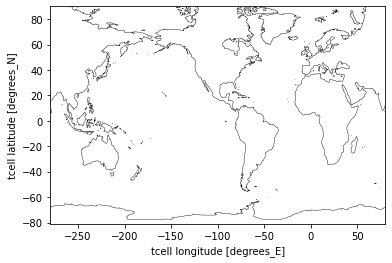

In [4]:
mask = (fgrd.ht.where(fgrd.ht>0)*0+1).fillna(0)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

Correlation between values

In [5]:
corr_lag2 = xr.zeros_like(f_sc.temp)
corr_lag2 = corr_lag2.assign_coords({'time':np.arange(12)})
for i in np.arange(len(f_sc.time)):
    corr_i = xr.corr(f_sc.SF_cv.roll(time = i, roll_coords = False) -fheat_mean.SF_cv.sum('st_ocean'),f_sc.temp-fmonth_mean.temp.isel(st_ocean = 0),dim = 'time')
    corr_i.load()
    corr_lag2[i,...]=corr_i
corr_lag2

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/a

<xarray.DataArray 'temp' (time: 12, yt_ocean: 1080, xt_ocean: 1440)>
dask.array<setitem, shape=(12, 1080, 1440), dtype=float32, chunksize=(1, 108, 144), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    st_ocean  float64 ...
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_conservative_temperature

Text(0, 0.5, 'Latitude ($^\\circ$N)')

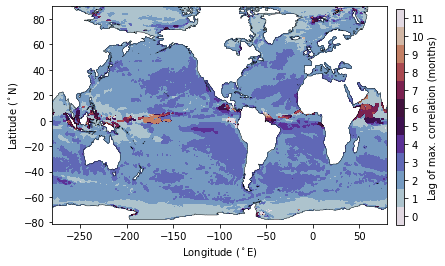

In [6]:
fig,ax = plt.subplots()
p1 = corr_lag2.idxmax('time').plot.contourf(cmap = 'twilight', levels = np.arange(13)-0.5, add_colorbar = False)
ax_cb = plt.axes([0.92,0.12,0.02,0.75])
cb = plt.colorbar(p1, cax = ax_cb, label = 'Lag of max. correlation (months)',ticks = np.arange(12))
mask.plot.contour(ax = ax, levels = [0.5],linewidths = 0.4, colors = 'k')

ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')


Text(0, 0.5, 'Latitude ($^\\circ$N)')

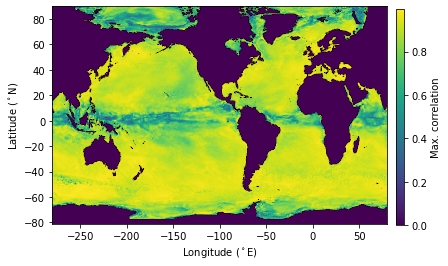

In [7]:
fig,ax = plt.subplots()
time = corr_lag2.idxmax('time')
p1 = corr_lag2.where(corr_lag2.time == time).sum('time').plot(add_colorbar = False)
ax_cb = plt.axes([0.92,0.12,0.02,0.75])
cb = plt.colorbar(p1, cax = ax_cb, label = 'Max. correlation')
mask.plot.contour(ax = ax, levels = [0.5],linewidths = 0.4, colors = 'k')

ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice 

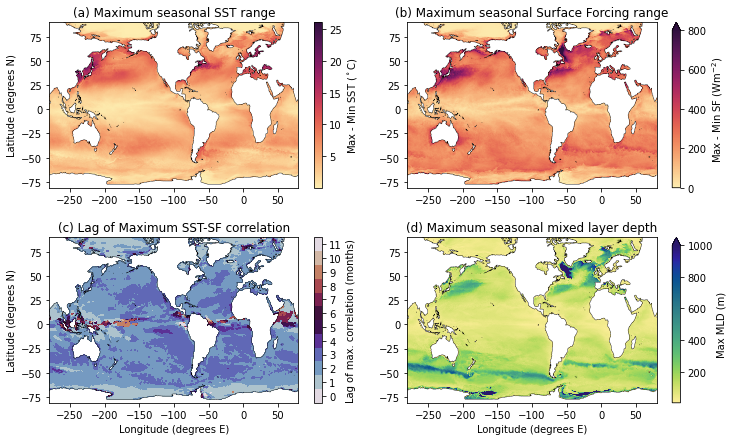

In [8]:
fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize = (12,7))

## plot max - min SST over seasonal cycle
(f_sc.temp.max('time')-f_sc.temp.min('time')).plot(ax = axes[0,0],cmap = cm.cm.matter, cbar_kwargs = {'label':'Max - Min SST ($^\circ$C)'} )
mask.plot.contour(ax = axes[0,0],levels = [0.5],linewidths = 0.4, colors = 'k')

axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Latitude (degrees N)')
axes[0,0].set_title('(a) Maximum seasonal SST range')

# plot max- min SF over seasonal cycle
temp = (f_sc.SF_cv.max('time')-f_sc.SF_cv.min('time'))
temp.where(temp!=0).plot(ax = axes[0,1],cmap = cm.cm.matter, vmin = 0, vmax = 800, cbar_kwargs = {'label':'Max - Min SF (Wm$^{-2}$)'})
mask.plot.contour(ax = axes[0,1],levels = [0.5],linewidths = 0.4, colors = 'k')

axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_title('(b) Maximum seasonal Surface Forcing range')

p1 = corr_lag2.idxmax('time').plot.contourf(ax = axes[1,0],cmap = 'twilight', levels = np.arange(13)-0.5, add_colorbar = False)
cb = plt.colorbar(p1, ax = axes[1,0], label = 'Lag of max. correlation (months)',ticks = np.arange(12))
mask.plot.contour(ax = axes[1,0], levels = [0.5],linewidths = 0.4, colors = 'k')

axes[1,0].set_xlabel('Longitude (degrees E)')
axes[1,0].set_ylabel('Latitude (degrees N)')
axes[1,0].set_title('(c) Lag of Maximum SST-SF correlation')
#axes[1,1].set_visible(False)

(f_sc.mld.max('time')).plot(ax = axes[1,1],cmap = cm.cm.haline_r, vmax = 1000, cbar_kwargs = {'label':'Max MLD (m)'})
mask.plot.contour(ax = axes[1,1],levels = [0.5],linewidths = 0.4, colors = 'k')
axes[1,1].set_title('(d) Maximum seasonal mixed layer depth')
axes[1,1].set_xlabel('Longitude (degrees E)')
axes[1,1].set_ylabel('')



fig.subplots_adjust(hspace = 0.3,wspace = 0.15)
fig.savefig('SST_SF_Corr.png',dpi = 200)